In [32]:
import cv2
import numpy as np
import os

from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans, vq
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [2]:
import os
import shutil
import numpy as np
from torchvision import datasets
from sklearn.metrics import make_scorer, precision_score

# Decorator turns into scorer object to be used with 
# grid search.
@make_scorer
def avg_precision(y_true, y_pred):
    """
    Average precision metric.
    Computes precision for each class independently
    then take average.
    Args:
        y_true (numpy.array): array of true y values. 
        y_pred(numpy.array): array of predicted y values.
    Returns:
        (float) average precision.
    
    """
    precision=[]
    for idx, label in enumerate(np.unique(y_true)):
        precision.append(precision_score(y_true == label, y_pred == label))
    return np.mean(precision)


def create_dataset(dir, transform=None, labeled=True):
    """
    Read in data and apply transformation.
    Args:
        dir (string): path to data folder
        transform (torchvision.Transform): transform to apply to data.
        labeled (bool): if data is not contained within subfolders indicating
            labels then create dummy folder and move data.
    Returns:
        (torch.Dataset) transformed data.
    """
    if not labeled:
        # get file names in folder
        file_names = os.listdir(dir)
        # create sub folder and move images
        target_dir = dir + '/dummy_class/'
        os.makedirs(target_dir)
        for file_name in file_names:
            shutil.move(os.path.join(dir, file_name), target_dir)

    dataset = datasets.ImageFolder(dir, transform)
    return dataset

In [3]:
import numpy as np
from PIL import Image
import cv2
from torch import flatten
from torchvision import transforms


##-------------------------------------- FEATURE EXTRACTION CLASSES -----------------------## 
class ZeroMeanTransform:
    def __call__(self, img):
        """
        Convert image to numpy array, 
        do any preprocessing you like then 
        convert back to the PIL Image.
        Args:
            img(PIL.Image): input image 
        Returns:
            (PIL.Image) processed image
        """
        x = np.array(img, dtype=np.float32)
        mean = np.mean(img)
        return Image.fromarray((x - mean))

class UnitLenTransform:
    def __call__(self, img):
        """
        Convert image to numpy array, 
        do any preprocessing you like then 
        convert back to the PIL Image.
        Args:
            img (PIL.Image): input image 
        Returns:
            (PIL.Image) processed image
        """
        x = np.array(img)
        cv2.normalize(x, x, alpha=1, dtype=cv2.CV_32F)
        return Image.fromarray(x)

##------------------------------------------------------------------------------------------##

##-------------------------------------- TRANSFORM FUNCTIONS -------------------------------##
def run3_transforms(resize=200):
    """
    Compute tiny image feature.
    Args:
        resize (int): the dimensions of the tiny image.
        crop (int): the dimensions of the center cropped array.
    Returns:
        (numpy.array): Tiny image flattened numpy array. 
            Dimensions are (num input samples, resize x resize) 
    """
    return transforms.Compose([transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(resize)
                               ZeroMeanTransform(),
                               UnitLenTransform(),
                               transforms.ToTensor(),
                               transforms.Lambda(lambda x: x.view(-1))])

##-------------------------------------------------------------------------------------------##

SyntaxError: invalid syntax (<ipython-input-3-0143e700ef55>, line 54)

In [4]:
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

In [5]:
def descriptorFormation(descriptor_list):
    descriptors = descriptor_list[0][1]
    img_count=0
    #Stacking
    for image_path, descriptor in descriptor_list[1:]:
        img_count+=1
        #Array of all features
        descriptors = np.vstack((descriptors, descriptor))
        #print("Stacking of Descriptors of image {} complete......".format(img_count))
    print("Descriptors stacked successfully!")
    descriptors_float = descriptors.astype(float)
    return(descriptors_float)

In [43]:
def getDescriptors(image_paths):
    descriptor_list = []
    img_count=0
    
    for image_path in image_paths:
        im = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        m, n = im.shape
        sift = cv2.SIFT_create()
        step_size = 5
        kp = [cv2.KeyPoint(x, y, size=step_size, octave=2) 
                  for y in range(0, m, step_size) 
                  for x in range(0, n, step_size)]
        _, dense_feat = sift.compute(im, kp)
        descriptor_list.append((image_path, dense_feat))
        img_count += 1
        #print("Extraction done for " + str(img_count))
    
    print("Feature extraction done!")
    return(descriptor_list)

In [7]:
train_path = 'images/training'
training_names = os.listdir(train_path)
image_paths = []
#Class label for all images
image_classes = []
class_id = 0
labelMap = {}

for training_name in training_names:
    labelMap[class_id] = training_name
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [8]:
def quantisation(image_paths, descriptor_list, k, codebook, scaler):
    im_features = np.zeros((len(image_paths), k), "float32")
    for i in range(len(image_paths)):
        descriptors = scaler.transform(descriptor_list[i][1])
        codes, distances = vq(descriptors, codebook)
        for code in codes:
            im_features[i][code] += 1
    return(im_features)       

## Feature Extraction and Selection

In [9]:
train_path = 'images/training'
training_names = os.listdir(train_path)
image_paths = []
#Class label for all images
image_classes = []
class_id = 0
labelMap = {}

for training_name in training_names:
    labelMap[class_id] = training_name
    dir = os.path.join(train_path, training_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [10]:
descriptor_list = getDescriptors(image_paths)

Feature extraction done!


In [11]:
descriptors_float = descriptorFormation(descriptor_list)

Descriptors stacked successfully!


In [12]:
print(len(descriptors_float))

4060424


In [13]:
#Normalising patches
scaler = StandardScaler()
normalised_descriptors = scaler.fit_transform(descriptors_float)

In [14]:
#Sample descriptors
sampled_descriptors = normalised_descriptors[np.random.choice(normalised_descriptors.shape[0], 500000, replace=False), :]

sampled_descriptors_for_gs = normalised_descriptors[np.random.choice(normalised_descriptors.shape[0], 10000, replace=False), :]

In [27]:
print(sampled_descriptors_for_gs.shape[0])

10000


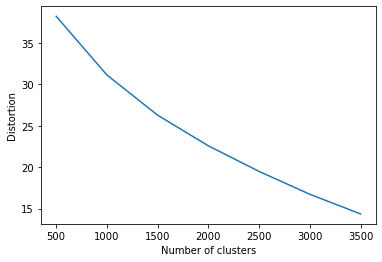

In [28]:
weighted_ssd = {}

for k in range(100, 1000, 100):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(sampled_descriptors_for_gs)
    weighted_ssd[k] = kmeans.inertia_/sampled_descriptors_for_gs.shape[0]


plt.figure()
plt.plot(list(weighted_ssd.keys()), list(weighted_ssd.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Avg weighted SSD")
plt.show()

In [34]:
# Create codebook
k = 500
voc, variance = kmeans(sampled_descriptors, k, 1)

In [35]:
# Quantisation of features to compute histogram of visual words
im_features = quantisation(image_paths,descriptor_list, k, voc, scaler)

## One-vs-Rest Classifier

In [36]:
# Scaling features for classifier
min_max_scaler = preprocessing.MinMaxScaler()
im_features_minmax = min_max_scaler.fit_transform(im_features)

In [37]:
model = LogisticRegression(multi_class='ovr', max_iter=100)
model.fit(im_features_minmax, image_classes)

LogisticRegression(multi_class='ovr')

In [38]:
# Training data performance
score = model.score(im_features_minmax, image_classes)
print(score)

0.942


## Test Data Run

In [44]:
test_path = 'images/testing'
testing_names = os.listdir(test_path)

test_image_paths = []
test_image_classes = []
test_image_names = []
test_class_id = 0

for testing_name in testing_names:
    test_dir = os.path.join(test_path, testing_name)
    test_image_paths.append(test_dir)
    test_image_names.append(testing_name)
        
test_descriptor_list = getDescriptors(test_image_paths)

Feature extraction done!


In [45]:
# Histogram of words and feature scaling
test_im_features = quantisation(test_image_paths, test_descriptor_list, k, voc, scaler)
test_im_features_minmax = min_max_scaler.transform(test_im_features)

In [46]:
pred_labels = model.predict(test_im_features_minmax)

In [47]:
# write output to file

with open('run3.txt', 'w') as f:
    for idx in range(len(test_image_names)):
        line = str(test_image_names[idx]) + " " + str(labelMap[pred_labels[idx]])
        f.write(line)
        f.write('\n')
f.close()